# Risk Estimation

### Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

# Ignorar todos los warnings
warnings.filterwarnings('ignore')
sns.set(style='darkgrid', palette='deep')

In [2]:
# Paths

root_path = "../"
data_path = os.path.join(root_path, "data/")
historical_data_path = os.path.join(data_path, "Historicos.csv")
current_data_path = os.path.join(data_path, "Vigentes.csv")

output_data_path = os.path.join(data_path, "risk_probabilities.xlsx")

In [3]:
# Import lato font
from matplotlib import font_manager

try:
    lato_path = "../Lato-Regular.ttf"
    lato_font = font_manager.FontProperties(fname=lato_path)
except:
    pass

print(os.path.isfile(lato_path))

True


### Import Data

In [4]:
df = pd.read_csv(historical_data_path)

In [5]:
df.head()

,ID,education,city,monthly_income,current_assets,credit_score,Monto,paid_in_full,loss
0,3822088719,undergraduate,Medellin,11474.07,40530.37,611,"$ 6,599,489",0,$ 0
1,5431270632,phd,Medellin,16686.98,61403.51,765,"$ 7,466,025",1,"$ 5,606,767"
2,2919928231,undergraduate,Cali,9928.97,51321.42,542,"$ 13,410,229",0,$ 0
3,3952534684,undergraduate,Bucaramanga,11331.48,23544.06,619,"$ 17,369,018",1,"$ 9,059,520"
4,5160944656,phd,Bogota,10146.78,27220.55,654,"$ 2,493,060",0,$ 0


In [6]:
# Fix paid in full definition

df["paid_in_full"] = df["paid_in_full"].map({0: 1, 1:0})

### EDA

Tipos de datos

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID              700 non-null    int64  
 1   education       700 non-null    object 
 2   city            700 non-null    object 
 3   monthly_income  700 non-null    float64
 4   current_assets  700 non-null    float64
 5   credit_score    700 non-null    int64  
 6   Monto           700 non-null    object 
 7   paid_in_full    700 non-null    int64  
 8   loss            700 non-null    object 
dtypes: float64(2), int64(3), object(4)
memory usage: 49.3+ KB


In [8]:
df.columns

Index(['ID', 'education', 'city', 'monthly_income', 'current_assets',
       'credit_score', 'Monto', 'paid_in_full', 'loss'],
      dtype='object')

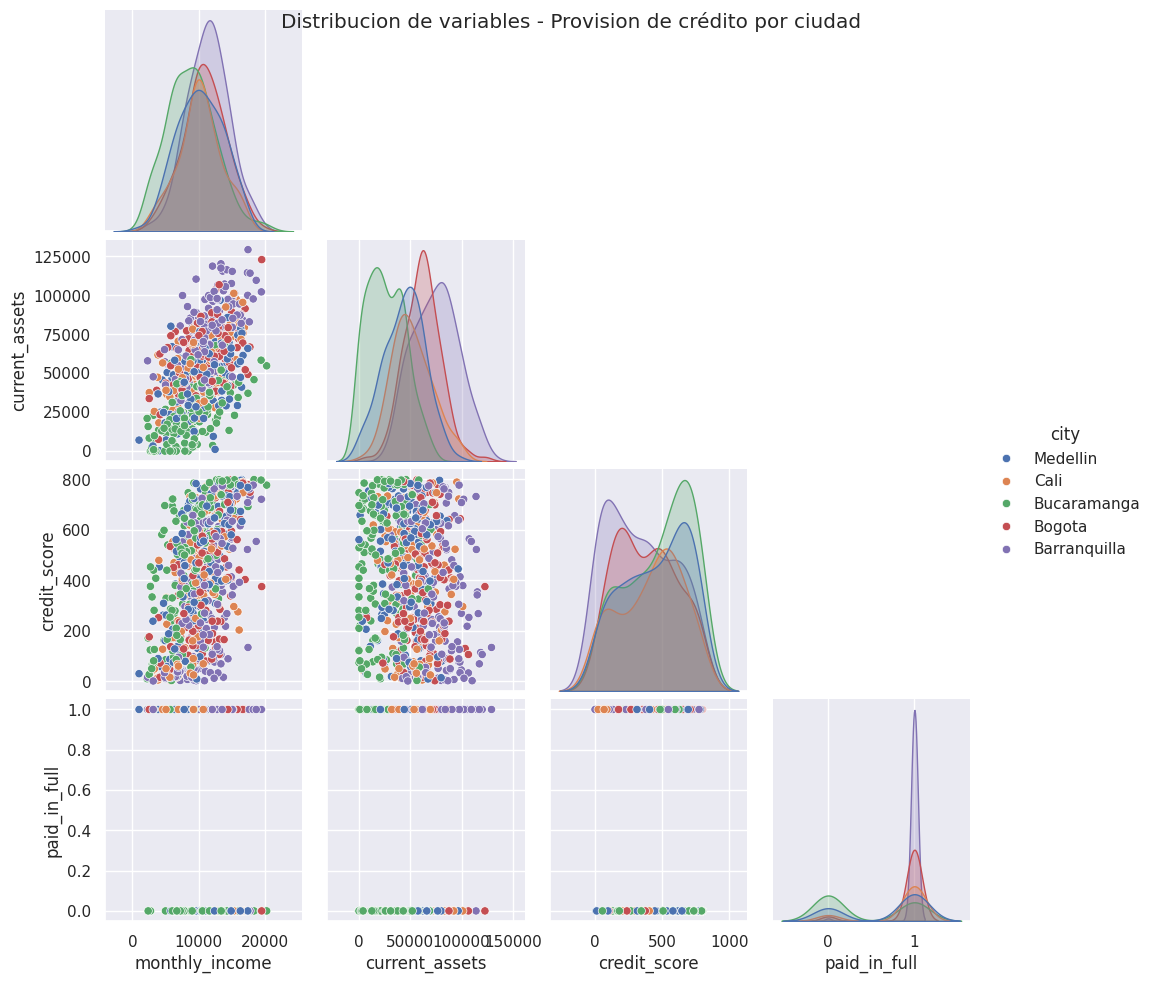

In [9]:
sns.pairplot(data=df[['city', 'monthly_income', 'current_assets','credit_score', 'Monto', 'paid_in_full', 'loss']], corner=True, hue="city")
plt.suptitle("Distribucion de variables - Provision de crédito por ciudad")
plt.savefig("../images/city_level_loans.png", format="png")
plt.show()

In [10]:
approvals_df = df[["city", "ID"]].groupby("city").count()
payments_df = df[["city", "paid_in_full"]].groupby("city").mean()
score_df = df[["city", "credit_score"]].groupby("city").mean()

join1 = approvals_df.join(payments_df, on="city", how="inner")
city_df = join1.join(score_df, on="city", how="inner")

In [11]:
city_df

,ID,paid_in_full,credit_score
city,,,
Barranquilla,165,0.987879,338.218182
Bogota,133,0.939850,385.097744
Bucaramanga,156,0.423077,481.230769
Cali,110,0.854545,414.963636
Medellin,136,0.676471,451.264706


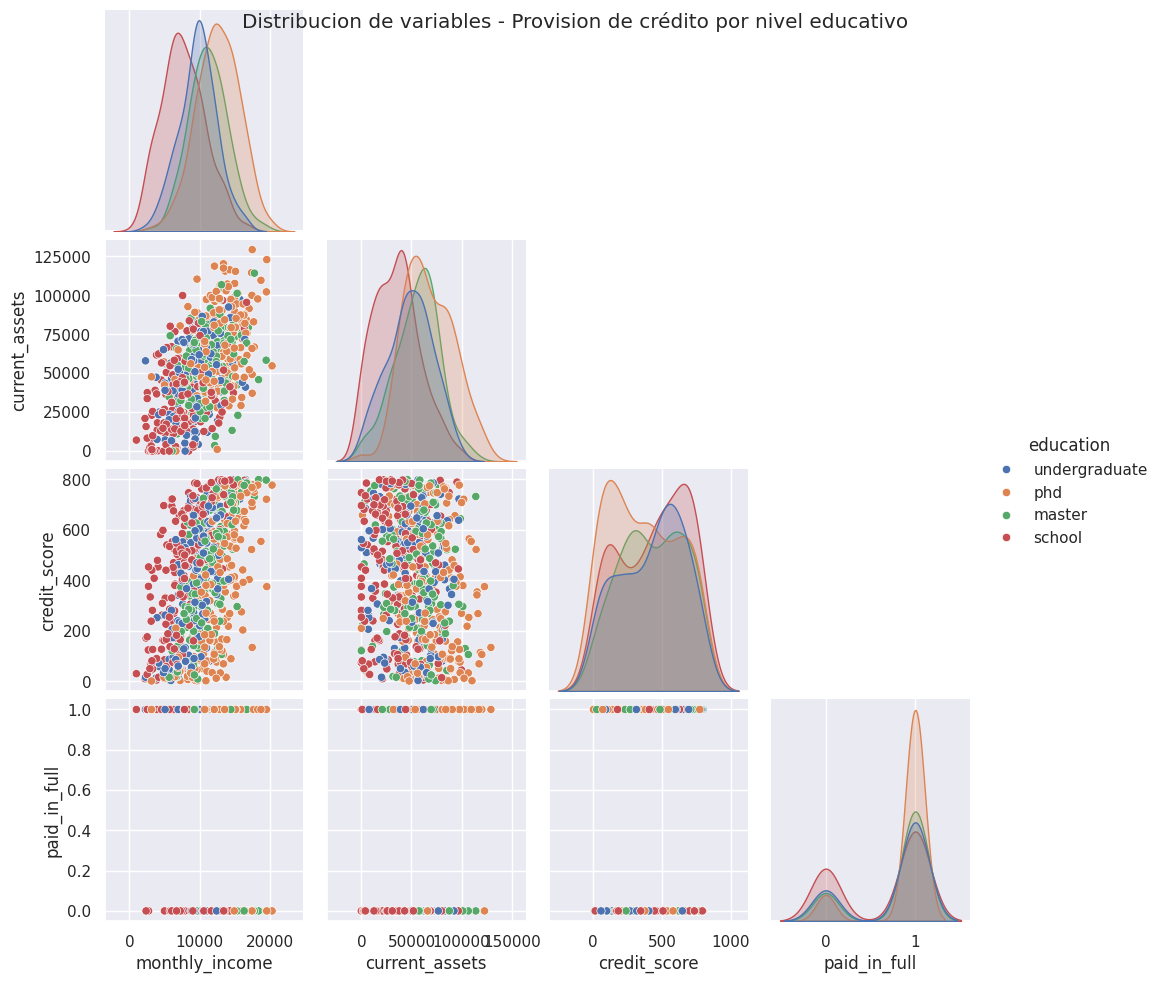

In [12]:
sns.pairplot(data=df[['education', 'monthly_income', 'current_assets','credit_score', 'Monto', 'paid_in_full', 'loss']], corner=True, hue="education")
plt.suptitle("Distribucion de variables - Provision de crédito por nivel educativo")
plt.savefig("../images/education_level_loans.png", format="png")
plt.show()

In [13]:
# correlation between education level and loan success
df[["education", "paid_in_full"]].groupby("education").mean()

,paid_in_full
education,
master,0.796178
phd,0.890000
school,0.631016
undergraduate,0.762821


In [14]:
# correlation between education level and loan success by city
df[["education", "city", "paid_in_full"]].groupby(["education", "city"]).mean().sort_values(by="paid_in_full")

paid_in_full
education     city                      
phd           Bucaramanga       0.250000
master        Bucaramanga       0.384615
phd           Medellin          0.411765
school        Bucaramanga       0.423077
undergraduate Bucaramanga       0.457143
master        Medellin          0.583333
undergraduate Medellin          0.684211
              Cali              0.833333
phd           Cali              0.842105
school        Medellin          0.844444
master        Cali              0.852941
phd           Bogota            0.895833
school        Cali              0.904762
master        Bogota            0.923077
              Barranquilla      0.971429
phd           Barranquilla      0.991071
undergraduate Barranquilla      1.000000
school        Bogota            1.000000
              Barranquilla      1.000000
undergraduate Bogota            1.000000

### Data Preprocessing

In [15]:
df_processed = df.copy()

df_processed.drop("ID", axis=1, inplace=True)

df_processed["city"] = df_processed["city"].map(
    {
        'Barranquilla': 0,
        'Bogota': 1,
        'Cali': 2,
        'Medellin': 3,
        'Bucaramanga': 4,
    }
)

df_processed["education"] = df_processed["education"].map(
    {
        'school': 0,
        'undergraduate': 1,
        'master': 2, 
        'phd': 3,
    }
)

In [16]:

# Convert to numerical
df_processed["city"] = pd.factorize(values=df_processed["city"])[0]
df_processed["education"] = pd.factorize(values=df_processed["education"])[0]

In [17]:
# TODO: Migrate to tables

for i in range(len(df.city.unique())):
    print(f"{df.city.unique()[i]} = {df_processed.city.unique()[i]}")

print("\n" + "=" * 30 + "\n")
for i in range(len(df.education.unique())):
    print(f"{df.education.unique()[i]} = {df_processed.education.unique()[i]}")

Medellin = 0
Cali = 1
Bucaramanga = 2
Bogota = 3
Barranquilla = 4


undergraduate = 0
phd = 1
master = 2
school = 3


In [18]:
# Do Bogotá and Barranquilla have better PIF rate than Medellin, Cali and Bucaramanga?

df_processed[["city", "paid_in_full"]].groupby("city").mean()

,paid_in_full
city,
0,0.676471
1,0.854545
2,0.423077
3,0.939850
4,0.987879


In [19]:
df_processed.head()

,education,city,monthly_income,current_assets,credit_score,Monto,paid_in_full,loss
0,0,0,11474.07,40530.37,611,"$ 6,599,489",1,$ 0
1,1,0,16686.98,61403.51,765,"$ 7,466,025",0,"$ 5,606,767"
2,0,1,9928.97,51321.42,542,"$ 13,410,229",1,$ 0
3,0,2,11331.48,23544.06,619,"$ 17,369,018",0,"$ 9,059,520"
4,1,3,10146.78,27220.55,654,"$ 2,493,060",1,$ 0


### Modeling

In [20]:
from sklearn.preprocessing import StandardScaler  # Scalar las variables para darles la misma importancia en el modelamiento
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split

In [21]:
# Limpiar la columna "Monto" eliminando los signos de dólar y las comas
df_processed['Monto'] = df_processed['Monto'].replace({'\$': '', ',': ''}, regex=True)

# Convertir la columna "Monto" a tipo float
df_processed['Monto'] = df_processed['Monto'].astype(float)

# Verificar el resultado
print(df_processed['Monto'].head())


0     6599489.0
1     7466025.0
2    13410229.0
3    17369018.0
4     2493060.0
Name: Monto, dtype: float64


In [22]:
# Split data between input and output variables

output_variable = "paid_in_full"
input_cols = list(df_processed.drop([output_variable, "loss"], axis=1).columns)
output_cols = [output_variable]

X = df_processed[input_cols]
y = df_processed[output_cols]

scaler = StandardScaler()
X = pd.DataFrame(data=scaler.fit_transform(X), columns=X.columns)

In [23]:
model = LogisticRegressionCV(cv=5, random_state=42)
model.fit(X, y)

LogisticRegressionCV(cv=5, random_state=42)

In [24]:
paid_in_full_likelihood = model.predict_proba(X)


In [25]:
df_processed["paid_in_full_likelihood"] = paid_in_full_likelihood[:, 1]

In [26]:
df_processed.head()

,education,city,monthly_income,current_assets,credit_score,Monto,paid_in_full,loss,paid_in_full_likelihood
0,0,0,11474.07,40530.37,611,6599489.0,1,$ 0,0.698181
1,1,0,16686.98,61403.51,765,7466025.0,0,"$ 5,606,767",0.214574
2,0,1,9928.97,51321.42,542,13410229.0,1,$ 0,0.895361
3,0,2,11331.48,23544.06,619,17369018.0,0,"$ 9,059,520",0.878653
4,1,3,10146.78,27220.55,654,2493060.0,1,$ 0,0.876656


### Export Model Predictions

In [27]:
# Predict current credit loans

df_current = pd.read_csv(current_data_path)

In [28]:
df_current.head()

,ID,education,city,monthly_income,current_assets,credit_score,Monto
0,6330126953,school,Cali,8939.64,43688.17,577,"$ 15,559,852"
1,1095851485,master,Bogota,6315.23,48059.17,16,"$ 523,804"
2,1207726431,undergraduate,Cali,13111.08,61617.49,663,"$ 6,340,907"
3,8874502266,undergraduate,Medellin,11469.24,40144.80,694,"$ 14,228,363"
4,4218374299,phd,Barranquilla,7196.54,56586.85,36,"$ 17,492,258"


In [29]:
# Limpiar columna monto

df_current['Monto'] = df_current['Monto'].replace({'\$': '', ',': ''}, regex=True)
df_current['Monto'] = df_current['Monto'].astype(float)

In [30]:
df_current.head()

,ID,education,city,monthly_income,current_assets,credit_score,Monto
0,6330126953,school,Cali,8939.64,43688.17,577,15559852.0
1,1095851485,master,Bogota,6315.23,48059.17,16,523804.0
2,1207726431,undergraduate,Cali,13111.08,61617.49,663,6340907.0
3,8874502266,undergraduate,Medellin,11469.24,40144.80,694,14228363.0
4,4218374299,phd,Barranquilla,7196.54,56586.85,36,17492258.0


In [31]:
df_current.drop("ID", axis=1, inplace=True)

# Convert to numerical
df_current["city"] = pd.factorize(values=df_current["city"])[0]
df_current["education"] = pd.factorize(values=df_current["education"])[0]

In [32]:
X = df_current[input_cols]
X = pd.DataFrame(data=scaler.transform(X), columns=X.columns)  #Solo transformar para prevenir data leakage

In [33]:
df_current["paid_in_full_likelihood"] = model.predict_proba(X)[:, 1]

In [34]:
df_current

,education,city,monthly_income,current_assets,credit_score,Monto,paid_in_full_likelihood
0,0,0,8939.64,43688.17,577,15559852.0,0.879129
1,1,1,6315.23,48059.17,16,523804.0,0.921479
2,2,0,13111.08,61617.49,663,6340907.0,0.343716
3,2,2,11469.24,40144.80,694,14228363.0,0.709632
4,3,3,7196.54,56586.85,36,17492258.0,0.927205
...,...,...,...,...,...,...,...
295,1,3,9033.51,71402.19,173,10312776.0,0.951878
296,0,1,6273.85,59904.20,214,4279734.0,0.962813
297,0,2,9783.13,13710.87,796,13599178.0,0.910609
298,1,1,14829.08,81929.52,718,15478847.0,0.561337


In [35]:
df_current.to_csv(output_data_path, index=False)  #TODO: Export in legible COls

In [36]:
import joblib
joblib.dump(model, '../models/risk_model.pkl')

['../models/risk_model.pkl']

### Model Explainability

In [37]:
import shap
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression


def model_predict(x):
    return model.predict_proba(x)

explainer = shap.KernelExplainer(model_predict, X.iloc[:100])  # Usamos una muestra del dataset para el explainer
shap_values = explainer.shap_values(X)

print(f"Forma de shap_values: {len(shap_values)}")


100%|██████████| 300/300 [00:01<00:00, 154.16it/s]

Forma de shap_values: 300


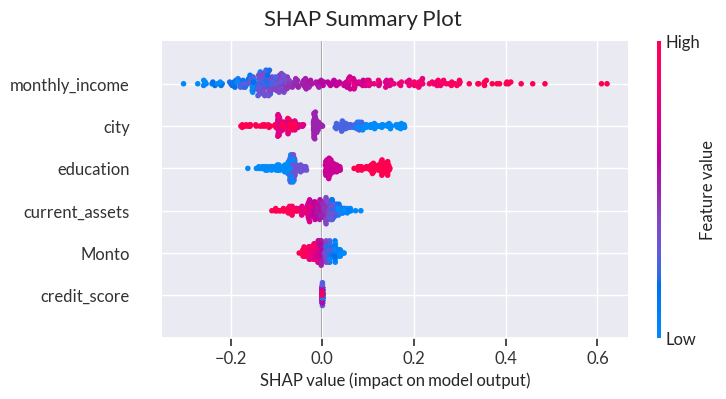

In [38]:
# Generate SHAP summary plot without showing it
shap.summary_plot(shap_values[:, :, 0], X, show=False)

# Get the current figure (created by SHAP)
fig = plt.gcf()

# Add a title with Lato font, and add extra space below (y < 1 to lower the title)
fig.suptitle("SHAP Summary Plot", fontsize=16, fontproperties=lato_font, y=1.02)

# Apply Lato font to all axes labels and ticks
for ax in fig.axes:
    # X and Y axis labels
    ax.xaxis.label.set_fontproperties(lato_font)
    ax.yaxis.label.set_fontproperties(lato_font)
    
    # Tick labels on both axes
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontproperties(lato_font)

# Save the figure
fig.savefig('../images/shap_summary_plot.png', dpi=300, bbox_inches='tight')

plt.show()
plt.close(fig)

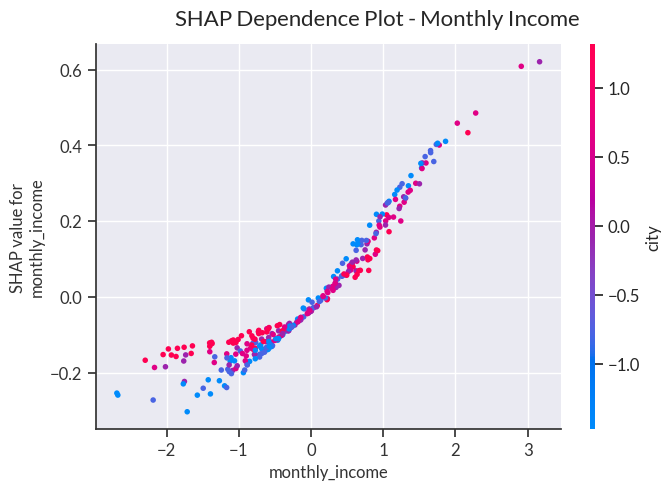

In [39]:
# Create dependence plot without showing it
shap.dependence_plot("monthly_income", shap_values[:, :, 0], X, show=False)

# Get the current figure created by SHAP
fig = plt.gcf()

# Add a suptitle with Lato font and extra space below the title
fig.suptitle("SHAP Dependence Plot - Monthly Income", fontsize=16, fontproperties=lato_font, y=0.95)

# Apply Lato font to all axes labels and tick labels
for ax in fig.axes:
    ax.xaxis.label.set_fontproperties(lato_font)
    ax.yaxis.label.set_fontproperties(lato_font)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontproperties(lato_font)

# Save the figure
fig.savefig('../images/shap_dependence_plot_monthly_income.png', dpi=300, bbox_inches='tight')

# Show the figure (optional)
plt.show()

# Close the figure
plt.close(fig)

In [40]:
# TODO: Build and analogic chart for SHAP

import numpy as np

def shap_to_probability(explainer, shap_sum):
    base_value = explainer.expected_value[0] 
    log_odds = base_value + shap_sum
    return 1 / (1 + np.exp(-log_odds))

print(shap_to_probability(explainer, -0.6))

0.41421537092877087


In [41]:
print("Gráficos guardados como 'shap_summary_plot.png' y 'shap_dependence_plot_monthly_income.png'.")

Gráficos guardados como 'shap_summary_plot.png' y 'shap_dependence_plot_monthly_income.png'.


### Calculo de Provision 

In [42]:
df_current.head()

,education,city,monthly_income,current_assets,credit_score,Monto,paid_in_full_likelihood
0,0,0,8939.64,43688.17,577,15559852.0,0.879129
1,1,1,6315.23,48059.17,16,523804.0,0.921479
2,2,0,13111.08,61617.49,663,6340907.0,0.343716
3,2,2,11469.24,40144.80,694,14228363.0,0.709632
4,3,3,7196.54,56586.85,36,17492258.0,0.927205


In [43]:
df_processed["default_prob"] = 1 - df_processed["paid_in_full_likelihood"]
df_current["default_prob"] = 1 - df_processed["paid_in_full_likelihood"]

In [44]:
df_processed["credit_provision"] = df_processed["Monto"] * df_processed["default_prob"]
df_current["credit_provision"] = df_current["Monto"] * df_current["default_prob"]

In [45]:
df_current.head()

,education,city,monthly_income,current_assets,credit_score,Monto,paid_in_full_likelihood,default_prob,credit_provision
0,0,0,8939.64,43688.17,577,15559852.0,0.879129,0.301819,4.696254e+06
1,1,1,6315.23,48059.17,16,523804.0,0.921479,0.785426,4.114092e+05
2,2,0,13111.08,61617.49,663,6340907.0,0.343716,0.104639,6.635034e+05
3,2,2,11469.24,40144.80,694,14228363.0,0.709632,0.121347,1.726571e+06
4,3,3,7196.54,56586.85,36,17492258.0,0.927205,0.123344,2.157571e+06


In [46]:
df_processed.head()

,education,city,monthly_income,current_assets,credit_score,Monto,paid_in_full,loss,paid_in_full_likelihood,default_prob,credit_provision
0,0,0,11474.07,40530.37,611,6599489.0,1,$ 0,0.698181,0.301819,1.991849e+06
1,1,0,16686.98,61403.51,765,7466025.0,0,"$ 5,606,767",0.214574,0.785426,5.864009e+06
2,0,1,9928.97,51321.42,542,13410229.0,1,$ 0,0.895361,0.104639,1.403227e+06
3,0,2,11331.48,23544.06,619,17369018.0,0,"$ 9,059,520",0.878653,0.121347,2.107681e+06
4,1,3,10146.78,27220.55,654,2493060.0,1,$ 0,0.876656,0.123344,3.075048e+05


In [47]:
historical_loss = df_processed['credit_provision'].sum()
current_credit_prov = df_current['credit_provision'].sum()

In [48]:
print(f"{'='*40}")
print(f"{'Historical Loss and Current Credit Provision':^40}")
print(f"{'='*40}")
print(f"Historical Loss: ${historical_loss:,.2f}")
print(f"Current Credit Provision: ${current_credit_prov:,.2f}")
print(f"{'='*40}")


Historical Loss and Current Credit Provision
Historical Loss: $1,491,510,172.71
Current Credit Provision: $683,316,676.72


In [49]:
# Statistics

prov_mean = df_processed['credit_provision'].mean()
prov_median = df_processed['credit_provision'].median()

In [50]:
print(f"{'='*40}")
print(f"{'Credit Provision Statistics':^40}")
print(f"{'='*40}")
print(f"Mean Credit Provision:   ${prov_mean:,.2f}")
print(f"Median Credit Provision: ${prov_median:,.2f}")
print(f"{'='*40}")


      Credit Provision Statistics       
Mean Credit Provision:   $2,130,728.82
Median Credit Provision: $1,214,036.97


In [51]:
# Provision Contribution by Sectors

df_final = df_current.copy()
df_final["city"] = df_final["city"].map(
    {
        0:'Barranquilla',
        1:'Bogota',
        2:'Cali',
        3:'Medellin',
        4:'Bucaramanga'
    }
)

df_final["education"] = df_final["education"].map(
    {
        0:'school',
        1:'undergraduate',
        2:'master', 
        3:'phd',
    }
)

df_sectors = df_final[["city", "education", "credit_provision"]].groupby(["city", "education"], as_index=False).sum()
df_sectors.to_csv("../data/sector_contribution_to_provision", index=False)


In [52]:
df_final

,education,city,monthly_income,current_assets,credit_score,Monto,paid_in_full_likelihood,default_prob,credit_provision
0,school,Barranquilla,8939.64,43688.17,577,15559852.0,0.879129,0.301819,4.696254e+06
1,undergraduate,Bogota,6315.23,48059.17,16,523804.0,0.921479,0.785426,4.114092e+05
2,master,Barranquilla,13111.08,61617.49,663,6340907.0,0.343716,0.104639,6.635034e+05
3,master,Cali,11469.24,40144.80,694,14228363.0,0.709632,0.121347,1.726571e+06
4,phd,Medellin,7196.54,56586.85,36,17492258.0,0.927205,0.123344,2.157571e+06
...,...,...,...,...,...,...,...,...,...
295,undergraduate,Medellin,9033.51,71402.19,173,10312776.0,0.951878,0.275822,2.844495e+06
296,school,Bogota,6273.85,59904.20,214,4279734.0,0.962813,0.218834,9.365500e+05
297,school,Cali,9783.13,13710.87,796,13599178.0,0.910609,0.099029,1.346708e+06
298,undergraduate,Bogota,14829.08,81929.52,718,15478847.0,0.561337,0.023007,3.561239e+05


In [53]:
import pandas as pd

# Cálculo de estadísticas
historical_loss = df_processed['credit_provision'].sum()
current_credit_prov = df_current['credit_provision'].sum()
prov_mean = df_processed['credit_provision'].mean()
prov_median = df_processed['credit_provision'].median()

stats_dict = {
    'Statistic': ['Historical Loss', 'Current Credit Provision', 'Mean Credit Provision', 'Median Credit Provision'],
    'Value': [historical_loss, current_credit_prov, prov_mean, prov_median]
}

stats_df = pd.DataFrame(stats_dict)

stats_df

,Statistic,Value
0,Historical Loss,1.491510e+09
1,Current Credit Provision,6.833167e+08
2,Mean Credit Provision,2.130729e+06
3,Median Credit Provision,1.214037e+06


In [54]:
stats_df.to_csv("../data/final_statistics.csv", index=False)